### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# # Suppress Warnings 
import warnings
warnings.filterwarnings("ignore")
random_state = 8

In [2]:
df = pd.read_csv('Cleaned_Data.csv')
df.drop('Unnamed: 0',axis =1,inplace =True)

In [3]:
df.columns

Index(['jobtitle', 'joburl', 'company', 'job_loc', 'job_search_term', 'Salary',
       'job_desc', 'bracket', 'low_salary', 'high_salary', 'Position',
       'senior', 'junior', 'Nomention', 'Freelance', 'Temporary', 'Contract',
       'Permanent', 'Sal_Convert', 'Sal_Dur', 'Sal_Low', 'Sal_High',
       'Sal_Avg'],
      dtype='object')

### First We try MLR Regression Model based on the available dummy columns (Since we don't have any one hot encoding in the data cleaning file, we can do this step directly on all columns of the dataframe). 


In [4]:
# Create the Target and Predictor Variables
y = df['Sal_Convert']

In [5]:
col =['senior','Freelance', 'Temporary','Contract', 'Permanent']
X = df[col]

In [6]:
lr = LinearRegression()
scores = cross_val_score(lr,X,y,cv=10)
print(scores)

[-0.46999722 -0.13754619  0.00556848  0.23265232 -0.24263823  0.06790364
  0.15261104  0.2241099   0.10566779 -0.09638067]


### Clearly the model is not Accurate and also variant. Next we use SGD Regressor 

In [7]:
## Using SGD Regressor
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
model = sgd.fit(X,y)
score = model.score(X,y)

# Cross Validation
sgdcv = cross_val_score(sgd,X,y,cv=5)
print(sgdcv)

[-0.15734234 -0.00274571  0.0417595   0.13315892 -0.11920749]


In [8]:
# The Decision Tree Model 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
regressor = DecisionTreeRegressor(criterion='mse')
model = regressor.fit(X, y)
Y_pred = model.predict(X)
feature_importances = regressor.feature_importances_

In [9]:
DTscore = model.score(X,y)
print('The accuracy of the decision tree DTscore is' , DTscore)

The accuracy of the decision tree DTscore is 0.09702145685114483


In [10]:
# Cross Validation
dtcv = cross_val_score(regressor,X,y,cv=10)
dtcv

array([-0.59191122, -0.13250233,  0.0296194 ,  0.27367919, -0.25452622,
        0.10298536,  0.14439611,  0.14022696, -0.06790584, -0.03438294])

In [11]:
df.columns

Index(['jobtitle', 'joburl', 'company', 'job_loc', 'job_search_term', 'Salary',
       'job_desc', 'bracket', 'low_salary', 'high_salary', 'Position',
       'senior', 'junior', 'Nomention', 'Freelance', 'Temporary', 'Contract',
       'Permanent', 'Sal_Convert', 'Sal_Dur', 'Sal_Low', 'Sal_High',
       'Sal_Avg'],
      dtype='object')

Certainly the model is highly variant as we didn't prune the tree.We can go ahead and try to prune it, however the accuracy is not high to begin with. This may be simply because of the fact these variables are poor predictors of the salary. 

In [12]:
## Now We Treat the problem as a Classification Problem

In [13]:
df.bracket.unique()

array(['High', 'Low'], dtype=object)

In [14]:
baseline = max(df.bracket.value_counts(normalize=True))
print(baseline)

0.5522388059701493


In [15]:
y=df[['bracket']]
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state=1)
x_train.shape

(268, 5)

In [16]:
y_train.shape

(268, 1)

In [17]:
DTClassifier = DecisionTreeClassifier(criterion='entropy',max_depth=3)
dtree = DTClassifier.fit(x_train,y_train)
ClassCV = cross_val_score(DTClassifier,x_train,y_train,cv=5)
print(ClassCV)
print(np.std(ClassCV))

[0.54545455 0.64814815 0.64150943 0.50943396 0.58490566]
0.053760801816123575


In [18]:
score = dtree.score(x_test,y_test)
print(score)

0.7313432835820896


###  The score is a bit better than the baseline of 0.55. However, cross validation test shows that the accuracy varies from 0.54 to 0.64. Thus, the predictors are not good for making any reliable predictions. Therefore, neither regression nor classification problem can be solved with these variables. Therefore, now we perform NLP on the Job description data to improve the accuracy score.

In [19]:
# Import all the libraries
import string
import re
from nltk.corpus import stopwords
from gensim.utils import lemmatize
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import accuracy_score,completeness_score,silhouette_score,confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB



### NLP Strategy
First we remove the stop words, then we lemmatize. Then we perform Count vectorization and TFIDF to find which words are important. From this we will try to establish which words (20-50) affect the salary most by doing further modelling.  

In [20]:
# We first bring everything to lower case in Job Description column
df['job_desc'] = [desc.lower() for desc in df['job_desc']]

In [21]:
# Define Stopwords
newstopwords = ['terms','conditions','work','qualification','staff','us','date','time','year',
               'role','skill','support','ability','click','apply','please','contact',
                'applicant','application','close','position','description','button',
               'selection','aboriginal','torre','strait','islander','resume','cv','key','criteria',
               'job','today','send','post','australian','rights','opportunity','process',
                'client','system','include','provide','cover','letter','candidate','need',
                'midnight','day','data','daylight','skill','south','sydney','western','analyst']
default_stopwords = nltk.corpus.stopwords.words('english')
added_stopwords = list(string.punctuation) + newstopwords
stopwords = set(default_stopwords).union(added_stopwords)

In [22]:
# Function to remove stop words and numbers and any emojis and non english characters.
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  # get rid of noise
    x = [w for w in x.split() if w not in set(stopwords)]  # remove stopwords
    return ' '.join(x)   

In [23]:
df['clean_job_desc'] = df['job_desc'].apply(preprocess)

In [24]:
# Function to lemmatize the job description
def genlemma (sentence):
    lemmatized_out = [wd.decode('utf-8').split('/')[0] for wd in lemmatize(sentence)]
    return ' '.join(lemmatized_out)

In [25]:
df['lem_output'] = df['clean_job_desc'].apply(genlemma)

In [26]:
df['lem_output'].head()

0    learn software ainsoff sydneystart february en...
1    hourparttime type permanent part classificatio...
2    yeareleventime webby awardwin freelancercom wo...
3    daytemporary contract scientist position open ...
4    yearcontractjob type fix term full location ns...
Name: lem_output, dtype: object

In [27]:
# Perform TFIDF Vectorization
vect = TfidfVectorizer()
dtm = vect.fit_transform(df['lem_output'])
features = vect.get_feature_names()
dtm.shape

(335, 4992)

####  Interpretation
The number of Features are way more than the rows. This will not create a good model. 
We need to look at the most important features (say 25 -50 in number) for interpretability.
For a good model, we may do PCA which can do well with very less number of features.

In [28]:
vect = TfidfVectorizer(max_features = 20,ngram_range= (2,5))
dtm = vect.fit_transform(df['lem_output'])
features = vect.get_feature_names()
dtm.shape

(335, 20)

Let us start modelling - First, we will try to solve the regression problem for salary data followed by classification problem. Since we have very small dataset, Baysian may be a lot useful. Also since forests and trees are open models, we will try to use them as well and 
see what is the output.

In [29]:
# Regression With NLP variables



In [30]:
# Linear Regression
y = df.Sal_Convert

n_gram =range(1,5)
for i in n_gram:
    vect = TfidfVectorizer(max_features = 5,ngram_range= (i,5))
    dtm = vect.fit_transform(df['lem_output'])
    X = dtm
    X_train_reg,X_test_reg,y_train_reg,y_test_reg = train_test_split(X,y,train_size =0.8,)
    cvscore = cross_val_score(lr,X_train_reg,y_train_reg,cv=5)
    print(f'The mean CV Score for n_gram = {i} is {round(cvscore.mean(),2)} and STD is {round(cvscore.std(),2)}')

The mean CV Score for n_gram = 1 is -0.03 and STD is 0.02
The mean CV Score for n_gram = 2 is -0.09 and STD is 0.08
The mean CV Score for n_gram = 3 is -0.05 and STD is 0.09
The mean CV Score for n_gram = 4 is -0.02 and STD is 0.07


In [31]:
# Tree
for i in n_gram:
    vect = TfidfVectorizer(ngram_range= (i,5))
    dtm = vect.fit_transform(df['lem_output'])
    X = dtm
    X_train_reg,X_test_reg,y_train_reg,y_test_reg = train_test_split(X,y,train_size =0.75,)
    regressor = DecisionTreeRegressor(criterion='mse')
    dtscore = cross_val_score(regressor,X_train_reg,y_train_reg,cv=5)
    print(f'The mean CV Score for n_gram = {i} is {round(dtscore.mean(),2)} and STD is {round(dtscore.std(),2)}')

The mean CV Score for n_gram = 1 is 0.06 and STD is 0.19
The mean CV Score for n_gram = 2 is 0.11 and STD is 0.38
The mean CV Score for n_gram = 3 is 0.58 and STD is 0.2
The mean CV Score for n_gram = 4 is 0.55 and STD is 0.12


The regression Fails even with the maximum number of features from the NLP. Therefore, it can be concluded that it is not possible to predict the actual salary of the person based on the job description.

# Tackling Q1 as a Classification Problem

Considering this as a supervised problem, following classfication algorithms may be tried - 
KNN, Logistic Regression, SVM, Naive Bayes and Random Forest.

In [32]:
# Setting up X and y variables for Classification and baseline
y_col= pd.Series (['bracket'])
y = pd.get_dummies(df,columns=y_col,drop_first =True)
baseline = max(df.bracket.value_counts(normalize=True))
print('The Base line accuracy is', round(baseline,2))

The Base line accuracy is 0.55


In [33]:
# Logistic Regression
y =df.bracket
logreg = LogisticRegression()
for i in n_gram:
    vect = TfidfVectorizer(ngram_range= (i,5))
    dtm = vect.fit_transform(df['lem_output'])
    X = dtm
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size =0.8,random_state = 8)
    logcvscore = cross_val_score(logreg,X_train,y_train,cv=10)
    print(f'The mean CV Score for n_gram = {i} is {round(logcvscore.mean(),2)} and STD is {round(logcvscore.std(),2)}')


The mean CV Score for n_gram = 1 is 0.81 and STD is 0.06
The mean CV Score for n_gram = 2 is 0.81 and STD is 0.06
The mean CV Score for n_gram = 3 is 0.81 and STD is 0.06
The mean CV Score for n_gram = 4 is 0.81 and STD is 0.06


The logistic regression will perform well because it takes into account more than 4500 variables for curve fitting. It is bound to be very correct. To explore further we plot the accuracy and standard deviation for logistic regression with varying predictor variables.

In [34]:
max_feat = np.arange(100,4800,200)
logcvscore_mean=np.ones(len(max_feat))
logcvscore_std = np.ones(len(max_feat))
def logcvs (max_feat,lem_op,cv=5):
    vect = TfidfVectorizer(max_features=max_feat)
    X = vect.fit_transform(lem_op)
    logcvscore = cross_val_score(logreg,X,y,cv=10)
    return np.mean(logcvscore),np.std(logcvscore)

for i in range(len(max_feat)):
    logcvscore_mean[i],logcvscore_std[i] =(logcvs(max_feat[i],df.lem_output))


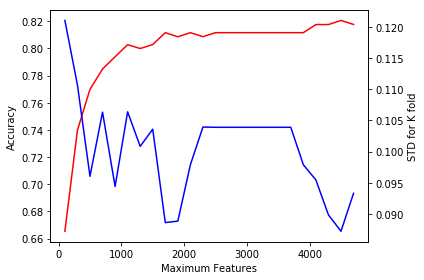

In [35]:
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(max_feat,logcvscore_mean,color ='red')
ax1.set(xlabel='Maximum Features',ylabel='Accuracy')
ax2.plot(max_feat,logcvscore_std,color = 'blue',)
ax2.set(ylabel = 'STD for K fold')
fig.tight_layout()

It ca be seen that for around 1500 features, the accuracy score saturates and standard deviation is minimize as well. Therefore, we now perform the train test split with logistic regression and consider 1500 number of features to calculate the confusion matrix. 

In [36]:
vect = TfidfVectorizer(max_features=4000)
dtm = vect.fit_transform(df['lem_output'])
X = dtm
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size =0.8,random_state =8)
model = logreg.fit(X_train,y_train)
y_pred = model.predict(X_test)
score = model.score(X_test,y_test)
print ('Score on test data is',score)
print('The Confusion Matrix on test data is given as:\n',confusion_matrix(y_test,y_pred))

Score on test data is 0.835820895522388
The Confusion Matrix on test data is given as:
 [[26 11]
 [ 0 30]]


In [37]:
vect = TfidfVectorizer(max_features=4000)
dtm = vect.fit_transform(df['lem_output'])
X = dtm
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size =0.8,random_state =8)
model = logreg.fit(X_train,y_train)
y_pred = model.predict(X)



Interestingly, there are no false negatives. In this context,it means that the algorithm does not predict the salary to be 'High' when it is actually 'Low'.

In [38]:
# from sklearn.metrics import roc_curve, auc
# fpr, tpr, _ = roc_curve(y_pred, y)
# roc_auc = auc(fpr, tpr)

In [39]:
# Plot of a ROC curve for class 1 (High Salary)
# plt.figure(figsize=[8,8])
# plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
# plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
# plt.xlim([-0.05, 1.0])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate', fontsize=18)
# plt.ylabel('True Positive Rate', fontsize=18)
# plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
# plt.legend(loc="lower right")
# plt.show()

In [40]:
# KNN with default values
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

for i in n_gram:
    vect = TfidfVectorizer(ngram_range= (i,100))
    dtm = vect.fit_transform(df['lem_output'])
    X = dtm
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size =0.8,random_state = 8)
    knncvscore = cross_val_score(knn,X_train,y_train,cv=10)
    print(f'The mean CV Score for n_gram = {i} is {round(knncvscore.mean(),2)} and STD is {round(knncvscore.std(),2)}')
model = knn.fit(X_train,y_train)
y_pred = model.predict(X_test)
score = model.score(X_test,y_test)
print ('Score on test data is',score)
print('The Confusion Matrix on test data is given as:\n',confusion_matrix(y_test,y_pred))

The mean CV Score for n_gram = 1 is 0.6 and STD is 0.1
The mean CV Score for n_gram = 2 is 0.64 and STD is 0.08
The mean CV Score for n_gram = 3 is 0.66 and STD is 0.09
The mean CV Score for n_gram = 4 is 0.51 and STD is 0.06
Score on test data is 0.6268656716417911
The Confusion Matrix on test data is given as:
 [[30  7]
 [18 12]]


In [41]:
# Support Vector Machine
svm = SVC(probability=True,decision_function_shape='ovo',degree = 100,kernel = 'linear')

for i in n_gram:
    vect = TfidfVectorizer(ngram_range= (i,5))
    dtm = vect.fit_transform(df['lem_output'])
    X = dtm
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size =0.8)
    svmcvscore = cross_val_score(svm,X_train,y_train,cv=10)
    print(f'The mean CV Score for n_gram = {i} is {round(svmcvscore.mean(),2)} and STD is {round(svmcvscore.std(),2)}')
model = svm.fit(X_train,y_train)
y_pred = model.predict(X_test)
score = model.score(X_test,y_test)
print ('Score on test data is',score)
print('The Confusion Matrix on test data is given as:\n',confusion_matrix(y_test,y_pred))

The mean CV Score for n_gram = 1 is 0.84 and STD is 0.08
The mean CV Score for n_gram = 2 is 0.82 and STD is 0.07
The mean CV Score for n_gram = 3 is 0.84 and STD is 0.07
The mean CV Score for n_gram = 4 is 0.85 and STD is 0.03
Score on test data is 0.9104477611940298
The Confusion Matrix on test data is given as:
 [[22  6]
 [ 0 39]]


In [42]:
# Naive Bayes
bnb = BernoulliNB()
       
for i in n_gram:
    vect = TfidfVectorizer(ngram_range= (i,5))
    dtm = vect.fit_transform(df['lem_output'])
    X = dtm
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size =0.8)
    bnbcvscore = cross_val_score(bnb,X_train,y_train,cv=10)
    print(f'The mean CV Score for n_gram = {i} is {round(bnbcvscore.mean(),2)} and STD is {round(bnbcvscore.std(),2)}')


The mean CV Score for n_gram = 1 is 0.83 and STD is 0.05
The mean CV Score for n_gram = 2 is 0.8 and STD is 0.07
The mean CV Score for n_gram = 3 is 0.82 and STD is 0.06
The mean CV Score for n_gram = 4 is 0.84 and STD is 0.07


The accurcay of Bernoulli NB is very high (higher than logistic regression) as expected since it works exceptionally well with fewer data points.
We therefore check for the effect of Max_Features.

In [43]:
max_feat = np.arange(100,4800,200)
bnbcvscore_mean=np.ones(len(max_feat))
bnbcvscore_std = np.ones(len(max_feat))
def bnbcvs (max_feat,lem_op,cv=5):
    vect = TfidfVectorizer(max_features=max_feat)
    X = vect.fit_transform(lem_op)
    bnbcvscore = cross_val_score(bnb,X,y,cv=10)
    return np.mean(bnbcvscore),np.std(bnbcvscore)

for i in range(len(max_feat)):
    bnbcvscore_mean[i],bnbcvscore_std[i] =(bnbcvs(max_feat[i],df.lem_output))

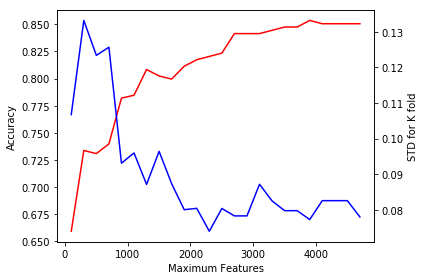

In [44]:
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(max_feat,bnbcvscore_mean,color ='red')
ax1.set(xlabel='Maximum Features',ylabel='Accuracy')
ax2.plot(max_feat,bnbcvscore_std,color = 'blue',)
ax2.set(ylabel = 'STD for K fold')
fig.tight_layout()

It has better accuracy and standard deviation than Logoistic Regression. Also, the accuracy does not saturate with increasing number of features, which is understandable since more number of features available means more apriori information which leads to better naive bayes. For around 400 features, the Bernoulli NB seems to perform quite well. Therefore Train - Test Split is done by considering 4000 features.

In [45]:
vect = TfidfVectorizer(max_features=4000)
dtm = vect.fit_transform(df['lem_output'])
X = dtm
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size =0.8,random_state =8)
model = bnb.fit(X_train,y_train)
y_pred = model.predict(X_test)
score = model.score(X_test,y_test)
print ('Score on test data is',score)
print('The Confusion Matrix on test data is given as:\n',confusion_matrix(y_test,y_pred))

Score on test data is 0.835820895522388
The Confusion Matrix on test data is given as:
 [[34  3]
 [ 8 22]]


In [46]:
max_feat = np.arange(100,4800,200)
score= np.ones(len(max_feat))
diff = np.ones(len(max_feat))
for i in range(len(max_feat)):
    vect = TfidfVectorizer(max_features=max_feat[i])
    dtm = vect.fit_transform(df['lem_output'])
    X = dtm
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size =0.8,random_state =8)
    model = bnb.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score [i] = model.score(X_test,y_test)
    diff[i] = confusion_matrix(y_test,y_pred)[1][0] - confusion_matrix(y_test,y_pred)[0][1]

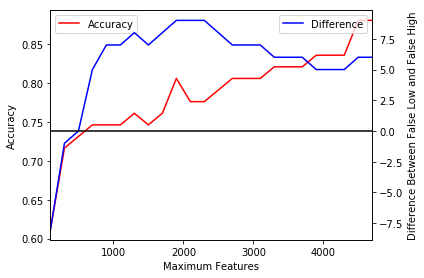

In [47]:
fig,ax1 = plt.subplots()

ax1.plot(max_feat,score,color ='red',label = 'Accuracy')
plt.legend(loc = 'best')
ax1.set(xlabel='Maximum Features',ylabel='Accuracy')
ax2 = ax1.twinx()
ax2.plot(max_feat,diff,color = 'blue',label = 'Difference')
ax2.set(ylabel = 'Difference Between False Low and False High')
ax2.set_xlim ([100,4700])
# plot a zero Line
line = np.zeros_like(max_feat)
ax2.plot(max_feat,line,color = 'black')

fig.tight_layout()
plt.legend(loc = 'best')

In figure above, the difference between False Lows and False Highs are plotted as a function of number of features. It can be seen that if false Low salary prediction is requried to be reduced than False Highs, smaller number of features (<400) should be considered. However, this also limits the accuracy of the model to 0.73.

In [48]:
rf = RandomForestClassifier()
       
for i in n_gram:
    vect = TfidfVectorizer(ngram_range= (i,5))
    dtm = vect.fit_transform(df['lem_output'])
    X = dtm
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size =0.8)
    rfcvscore = cross_val_score(rf,X_train,y_train,cv=10)
    print(f'The mean CV Score for n_gram = {i} is {round(rfcvscore.mean(),2)} and STD is {round(rfcvscore.std(),2)}')


The mean CV Score for n_gram = 1 is 0.81 and STD is 0.07
The mean CV Score for n_gram = 2 is 0.84 and STD is 0.07
The mean CV Score for n_gram = 3 is 0.81 and STD is 0.06
The mean CV Score for n_gram = 4 is 0.8 and STD is 0.06


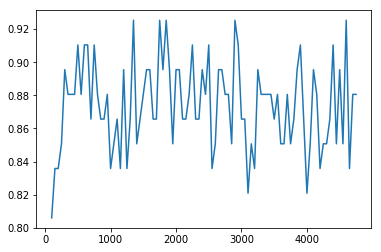

In [49]:
# Now we find out the effect of number of features
rf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto',random_state = 8)
max_feat = np.arange(100,4800,50)
score = np.ones(len(max_feat))

for i in range(len(max_feat)):
    vect = TfidfVectorizer(max_features=max_feat[i])
    dtm = vect.fit_transform(df['lem_output'])
    X = dtm
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size =0.8,random_state =8)
    model = rf.fit(X_train,y_train)
#     y_pred = model.predict(X_test)
    score [i] = model.score(X_test,y_test)
plt.plot(max_feat,score)   

In [50]:
## Random Forest ()
# The Tree has a feature that the model is very open
# Now we find the feature importance using differnt N Grams
vect = TfidfVectorizer(max_features =10,ngram_range=(2,4)) # Change to find differnt ngrams
dtm = vect.fit_transform(df['lem_output'])
X = dtm
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size =0.8,random_state =8)

rf = RandomForestClassifier(n_estimators=10, max_depth=None, max_features='auto',random_state = 8)
model = rf.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = model.score(X_test,y_test)
print('The Test Score is :',score)
rfcvscore =cross_val_score(rf,X_train,y_train,cv=5)
print(f'The mean CV Score is {round(rfcvscore.mean(),2)} and STD is {round(rfcvscore.std(),2)}')
confusion_matrix(y_test,y_pred)

The Test Score is : 0.6268656716417911
The mean CV Score is 0.63 and STD is 0.04


array([[13, 24],
       [ 1, 29]], dtype=int64)

In [51]:
# Get the top 10 features 
vect.get_feature_names()
rf.feature_importances_
diction = dict({'feature':vect.get_feature_names(),'importance':rf.feature_importances_})


In [52]:
feature_importances = pd.DataFrame(diction)
feature_importances.sort_values(by='importance', ascending=False)


,feature,importance
7,problem solve,0.174590
1,communication skill,0.135684
8,skill experience,0.118295
0,business process,0.107582
5,machine learn,0.094642
9,year experience,0.093393
3,experience working,0.084872
6,month contract,0.079518
4,internal external,0.070237
2,computer science,0.041187


It can be seen that the model works well even with features as less as 10. Also, this model has quite high accuracy comparable to the Logistic regression but has leasser variance.

### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

In [53]:
df.job_search_term.unique()

array(['Data+Scientist', 'Data+Analyst', 'Business+Analyst',
       'Data+Engineer'], dtype=object)

Here we have to find out if it is possible to classify the job ad for different role based on its contents.

In [54]:
y = df.job_search_term
baseline = y.value_counts(normalize=True)
print('The baseline is ',round(max(baseline),2))

The baseline is  0.35


In [55]:
# We perform multinomial Naive bayes

In [56]:
mnb = MultinomialNB()

vect = TfidfVectorizer()
X = vect.fit_transform(df['lem_output'])
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state=8)
model  = mnb.fit(X_train,y_train)
score = model.score(X,y)
predict = model.predict(X)
diction = {'Actual':y,'Predicted':predict}
df_predict = pd.DataFrame(diction)

print('The Score with Naive Bayes is',score)
print(confusion_matrix(y,predict))

The Score with Naive Bayes is 0.6059701492537314
[[108   9   0   0]
 [ 41  72   0   1]
 [ 30  17  20   0]
 [ 12  22   0   3]]


In [57]:
# Using Decision Tree Classifier

vect = TfidfVectorizer()
X = vect.fit_transform(df['lem_output'])
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state=8)
model  = DTClassifier.fit(X_train,y_train)
score = model.score(X_test,y_test)
predict = model.predict(X)
diction = {'Actual':y,'Predicted':predict}
df_predict = pd.DataFrame(diction)

print('The Score with Decision Tree Classifer is',score)
print(confusion_matrix(y,predict))

The Score with Decision Tree Classifer is 0.44776119402985076
[[94 20  3  0]
 [57 44  0 13]
 [13 12 33  9]
 [ 0  7  0 30]]


In [58]:
# Using Random Forest
rf = RandomForestClassifier()
vect = TfidfVectorizer(max_features=20)
y= df.job_search_term
X = vect.fit_transform(df['lem_output'])
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state=8)
model  = rf.fit(X_train,y_train)
score = model.score(X,y)
predict = model.predict(X)
diction = {'Actual':y,'Predicted':predict}
df_predict = pd.DataFrame(diction)

print('The Score with Random Tree Classifer is',score)
print(confusion_matrix(y,predict))


The Score with Random Tree Classifer is 0.7611940298507462
[[90 22  3  2]
 [16 90  1  7]
 [ 9  9 45  4]
 [ 0  6  1 30]]


In [59]:
vect.get_feature_names()
rf.feature_importances_
diction = dict({'feature':vect.get_feature_names(),'importance':rf.feature_importances_})

In [60]:
feature_importances = pd.DataFrame(diction)
feature_importances.sort_values(by='importance', ascending=False)

,feature,importance
1,business,0.101368
5,experience,0.074281
0,analysis,0.060859
14,skill,0.057979
4,development,0.057482
2,design,0.057434
16,strong,0.055400
17,team,0.051648
6,include,0.051304
9,project,0.050437


While this is better than the 34% baseline. We will next look only at the data scientist job and see if we can predict it.

In [61]:
col = pd.Series(['job_search_term'])
df_new = pd.get_dummies(df,columns=col)

# Feature Engineering

In this problem, feature enginerering is important. To distinguish beteen a data scientist and data engineer, caertain word will be more frequently use

While this is better than the 34% baseline. We will next look only at the data scientist job and see if we can predict it.

In [62]:
search_terms = ['regression','classification','machine','learning','modelling','predict',
            'hadoop','spark','big data','sql','java','closure','database','git','cloud',
               'python','r','statistics','model','analysis','finance','timeseries']

In [63]:
def text_search(row):
    
    new_row=[]
    for item in search_terms:
        if item in row:
            new_row.append(item)
    return ' '.join(new_row)

In [64]:
df['new_search'] = df.job_desc.apply(text_search)

In [65]:
def bow_sorted(df_cat):
    cvec=CountVectorizer(vocabulary=search_terms)
    X = cvec.fit_transform(df_cat)
    bow = X.toarray()
    bow_sum = bow.sum(axis=0)
    feat = cvec.get_feature_names()
    bow_dict = {'bow':bow_sum,'features':feat}
    df_bow = pd.DataFrame(bow_dict)
    ret_df = df_bow.sort_values(by= 'bow',ascending= False)
    return ret_df

In [66]:
def text_search(row):
    
    new_row=[]
    for item in search_terms:
        if item in row:
            new_row.append(item)
    return ' '.join(new_row)

In [67]:
df_ds =df[df.job_search_term == 'Data+Scientist']
df_de =df[df.job_search_term == 'Data+Engineer']
df_da =df[df.job_search_term == 'Data+Analyst']
df_ba =df[df.job_search_term == 'Business+Analyst']

In [68]:
df_ds['lem_DS'] = df['new_search'].apply(genlemma)
df_de['lem_DS'] = df['new_search'].apply(genlemma)
df_da['lem_DS'] = df['new_search'].apply(genlemma)
df_ba['lem_DS'] = df['new_search'].apply(genlemma)

In [69]:
ds_bow = bow_sorted(df_ds['lem_DS'])
da_bow = bow_sorted(df_da['lem_DS'])
de_bow = bow_sorted(df_de['lem_DS'])
ba_bow = bow_sorted(df_ba['lem_DS'])

In [70]:
da_bow

,bow,features
19,69,analysis
18,44,model
9,34,sql
20,20,finance
12,19,database
13,18,git
4,16,modelling
2,13,machine
15,12,python
7,6,spark


In [71]:
ds_bow

,bow,features
15,18,python
18,16,model
2,14,machine
19,12,analysis
4,11,modelling
5,11,predict
9,11,sql
12,9,database
7,6,spark
13,6,git



### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

In [72]:
# The Logistic Regression is very good in not labeling a low salary salary as high salary. So we use that for this problem.
# Tweaking the False positives and negatives is already tackled in problem 1 solution.